# Pace Tables

The race history chart provides a useful way of reviewing the evolution of a race, but sometimes it can be hard to read off how much faster or slower one car is than another at any particular point in a race.

*Pace tables* and *pace charts* are an attempt to try to highlight pace differences for drivers on each lap of the race.

## Pace Tables

*Pace tables* use driver relative rebased laptime deltas to show the pace difference for a named driver relative to other drivers.

Pace may be given as a speed delta (in terms of s / km difference) or as a laptime delta.

The s / km pace is given as:

`laptime_delta / circuit length`

In [1]:
%matplotlib inline

import pandas as pd

In [2]:
url = 'http://fiawec.alkamelsystems.com/Results/08_2018-2019/07_SPA%20FRANCORCHAMPS/267_FIA%20WEC/201905041330_Race/Hour%206/23_Analysis_Race_Hour%206.CSV'


In [113]:
laptimes = pd.read_csv(url, sep=';').dropna(how='all', axis=1)
laptimes.columns = [c.strip() for c in laptimes.columns]

#Tidy the data a little... car and driver number are not numbers
laptimes[['NUMBER','DRIVER_NUMBER']] = laptimes[['NUMBER','DRIVER_NUMBER']].astype(str)

# Enrichment
# Add the parent dir to the import path
import sys
sys.path.append("../py")

# Import contents of the utils.py package in the parent directory
from utils import *

# Get laptimes in seconds
laptimes['LAP_TIME_S'] = laptimes['LAP_TIME'].apply(getTime)

# Find accumulated time in seconds
laptimes['ELAPSED_S']=laptimes['ELAPSED'].apply(getTime)
laptimes['PIT_TIME_S']=laptimes['PIT_TIME'].apply(getTime)

# Find position based on accumulated laptime
laptimes = laptimes.sort_values('ELAPSED_S')
laptimes['POS'] = laptimes.groupby('LAP_NUMBER')['ELAPSED_S'].rank()

# Find leader naively
laptimes['leader'] = laptimes['POS']==1

# Find lead lap number
laptimes['LEAD_LAP_NUMBER'] = laptimes['leader'].cumsum()

laptimes.head()

,NUMBER,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,...,CLASS,GROUP,TEAM,MANUFACTURER,LAP_TIME_S,ELAPSED_S,PIT_TIME_S,POS,leader,LEAD_LAP_NUMBER
2381,7,1,1,2:00.155,0,NaN,33.767,0,56.631,0,...,LMP1,H,Toyota Gazoo Racing,Toyota,120.155,120.155,NaN,1.0,True,1
2876,8,1,1,2:01.977,0,NaN,34.280,0,57.610,0,...,LMP1,H,Toyota Gazoo Racing,Toyota,121.977,121.977,NaN,2.0,False,1
262,17,1,1,2:03.259,0,NaN,35.742,0,56.454,0,...,LMP1,NaN,SMP Racing,BR Engineering,123.259,123.259,NaN,3.0,False,1
777,3,2,1,2:03.739,0,NaN,36.035,0,56.644,0,...,LMP1,NaN,Rebellion Racing,Rebellion,123.739,123.739,NaN,4.0,False,1
130,11,3,1,2:05.631,0,NaN,37.247,0,57.103,0,...,LMP1,NaN,SMP Racing,BR Engineering,125.631,125.631,NaN,5.0,False,1


Lap time deltas can be calculated for each lap as follows, rebasing the deltas relative to the laptimes for a particular car as given by the `rebase` car number:

In [383]:
laptimes_wide = laptimes.pivot(index='NUMBER',
                                columns='LAP_NUMBER',
                                values='LAP_TIME_S')

rebase = "8" # Find lap time deltas to the corresponding lap time for this car

pace = (laptimes_wide - laptimes_wide.loc[rebase])
pace.head()

LAP_NUMBER,1,2,3,4,5,6,7,8,9,10,...,124,125,126,127,128,129,130,131,132,133
NUMBER,,,,,,,,,,,,,,,,,,,,,
1,4.372,2.361,3.374,-7.484,5.685,3.643,4.113,3.952,3.698,11.731,...,42.057,146.686,129.539,84.862,-80.073,-115.998,-46.946,NaN,NaN,NaN
11,3.654,2.387,-5.218,-34.390,40.722,2.706,2.247,0.580,0.779,-6.233,...,14.039,32.952,6.204,31.620,-37.441,-59.601,-47.800,-9.067,-6.163,NaN
17,1.282,2.157,-4.018,-34.666,47.856,4.289,3.719,1.460,3.561,10.756,...,13.925,61.330,18.359,97.281,-30.620,-107.970,-59.274,-7.974,NaN,NaN
26,8.227,6.972,5.583,-10.291,4.812,5.457,5.744,1.153,5.188,6.336,...,66.999,133.632,71.101,37.932,-90.136,-118.294,NaN,NaN,NaN,NaN
28,10.864,9.560,9.018,-13.359,3.764,6.165,5.963,0.701,2.509,7.228,...,62.199,39.627,-5.653,13.932,-97.131,NaN,NaN,NaN,NaN,NaN


We can style the table to show how much time the rebased car made or lost on each lap compared to other cars.

In [385]:
#In a live notebook, this produces a styled bar chart within each cell
pace.T[['3','11']].head(20).style.bar(align='zero', color=['#d65f5f', '#5fba7d'])

NUMBER,3,11
LAP_NUMBER,,
1,1.762,3.654
2,2.137,2.387
3,0.872,-5.218
4,-14.597,-34.39
5,-0.441,40.722
6,2.517,2.706
7,4.647,2.247
8,0.62,0.58
9,0.811,0.779


An alternative but equivalent way of manipulating the data is to select on the basis of index value, and then transpose the dataframe.

In [386]:
pace.loc[['8','3','11']].T.head()

NUMBER,8,3,11
LAP_NUMBER,,,
1,0.0,1.762,3.654
2,0.0,2.137,2.387
3,0.0,0.872,-5.218
4,0.0,-14.597,-34.390
5,0.0,-0.441,40.722


Data in this wide format, indexed by lapnumber and with columns containing rebased delta times on each lap for each car, can be plotted from directly:

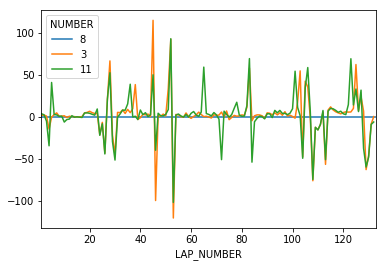

In [118]:
pace.loc[['8','3','11']].T.plot();

We can also generate the accumulated delta times for each car:

In [212]:
pace.loc[['8','3','11']].T.cumsum().head()

NUMBER,8,3,11
LAP_NUMBER,,,
1,0.0,1.762,3.654
2,0.0,3.899,6.041
3,0.0,4.771,0.823
4,0.0,-9.826,-33.567
5,0.0,-10.267,7.155


And then plot those:

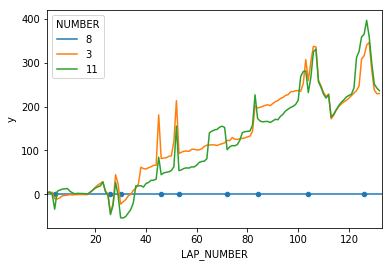

In [119]:
ax = pace.loc[['8','3','11']].T.cumsum().plot();

#Need to overplot each with pit events
inpitlaps = laptimes[(laptimes['NUMBER']==rebase) & ~(laptimes['PIT_TIME'].isnull())]
inpitlaps.loc[:,'y']=0
inpitlaps.plot.scatter(x='LAP_NUMBER',y='y', ax=ax);

### Plotting Using plotly Charts

We can also plot charts using the *plotly* charting library.

This provides us with a slightly different grammar for creating charts, albeit equally, if not more expressive, than the basic *pandas* plotting tools.

To create a simple time series chart, we need to put the data into a long format:

In [209]:
long_pace = pace.loc[['8','3','11']].T.cumsum().reset_index().melt(id_vars='LAP_NUMBER',
                                                                   value_name='ACCUMULATED_DELTA')
long_pace.head()

,LAP_NUMBER,NUMBER,ACCUMULATED_DELTA
0,1,8,0.0
1,2,8,0.0
2,3,8,0.0
3,4,8,0.0
4,5,8,0.0


We can then plot directly from this dataframe:

In [210]:
import plotly.express as px

fig = px.line(long_pace, x="LAP_NUMBER", y="ACCUMULATED_DELTA", color='NUMBER')
fig.show()

We can overplot the chart through the addition of extra traces:

In [215]:
import plotly.graph_objects as go
fig.add_trace(go.Scatter(x=inpitlaps['LAP_NUMBER'], y=inpitlaps['y'],
                         mode='markers', name='Pit stops'))

## Plotting Against Elapsed Time

One of the problems with this view is if cars are several laps apart, in which case to compare pace we really need to be comparing times relative to the lead lap or elapsed time, otherwise we may be comparing laptimes recorded at very different elapsed race times and possibly different conditions.

In [205]:
laptimes_wide_elapsed = laptimes.pivot(index='NUMBER',
                                columns='LAP_NUMBER',
                                values='LAP_TIME_S')
rebase = "8"
pace = (laptimes_wide - laptimes_wide.loc[rebase])

In [133]:
#merge the pace back in to laptimes, then plot against the elapsed time
#We can get the delats by NUMBER and LAP_NUMBER
pd.melt(pace.reset_index(), id_vars=['NUMBER']).head()

,NUMBER,LAP_NUMBER,value
0,1,1,4.372
1,11,1,3.654
2,17,1,1.282
3,26,1,8.227
4,28,1,10.864


In [161]:
#Merge this with the elapsed time
tmp = pd.melt(pace.reset_index(),
              id_vars=['NUMBER']).merge(laptimes[['NUMBER','LAP_NUMBER','ELAPSED_S']])
tmp.head()

,NUMBER,LAP_NUMBER,value,ELAPSED_S
0,1,1,4.372,126.349
1,11,1,3.654,125.631
2,17,1,1.282,123.259
3,26,1,8.227,130.204
4,28,1,10.864,132.841


In [173]:
tmp['cumvalue'] = tmp.groupby('NUMBER')['value'].cumsum()

,NUMBER,LAP_NUMBER,value,ELAPSED_S,cumvalue
0,1,1,4.372,126.349,4.372
1,11,1,3.654,125.631,3.654
2,17,1,1.282,123.259,1.282
3,26,1,8.227,130.204,8.227
4,28,1,10.864,132.841,10.864


In [163]:
fig = px.line(tmp[tmp['NUMBER'].isin(['11','3','8'])],
              x="ELAPSED_S", y="value", color='NUMBER')
fig.show()

In [174]:
fig = px.line(tmp[tmp['NUMBER'].isin(['11','3','8'])],
              x="ELAPSED_S", y="cumvalue", color='NUMBER')
fig.show()

One thing we notice is that the pace table and charts are cluttered by the inlap and outlap times...

It may be better to try to neutralise those (for each car including the rebased car )and deal with a pit analysis more specifically elsewhere, such as by comparing inlaps and outlap times,and perhaps also making comparisons relative to flying lap just before the inlap and just after the outlap.

### Generating a pit time neutralistion mask

The *pandas* [`DataFrame.mask()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mask.html) method lets us replace values in a dataframe if the corresponding mask element is true.

This means we can find the delta times on each lap and then neutralise the ones that are associated either with the inlap or outlap of the rebase car, or the inlap or outlap of each other car.

*Bear in mind that in general deltas measured relative to `LAP_NUMBER` may be recorded at very different elapsed race times, although  when comparing cars that are directly racing each other, they are likely to be on the same lap, or thereabouts, on any given lead lap.*

The resulting "masked" delta times table will not give a true summary of all the delta times, and the accumulated delta time will be incorrect, but we will get a cleaner view of the pace in the intervening periods.

In [230]:
#laptimes.pivot(index='NUMBER',columns='LAP_NUMBER', values='PIT_TIME_S')
laptimes['INLAP'] = (laptimes['CROSSING_FINISH_LINE_IN_PIT'] == 'B')
laptimes['OUTLAP'] = ~laptimes['PIT_TIME'].isnull()

laptimes['PITMASK'] = laptimes['INLAP'] | laptimes['OUTLAP']

#Go defensive making sure we have no NA values
pitmask = laptimes.pivot(index='NUMBER', columns='LAP_NUMBER', values='PITMASK').fillna(False)
pitmask.head()

LAP_NUMBER,1,2,3,4,5,6,7,8,9,10,...,124,125,126,127,128,129,130,131,132,133
NUMBER,,,,,,,,,,,,,,,,,,,,,
1,False,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
11,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
26,False,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
28,False,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [284]:
#Mask the times for each car's inlaps and outlaps
masked_pace = pace.mask(pitmask, 0)
#We also need to and each row with the inlaps and outlaps for the rebased row
#pitmask.loc[rebase].T gives the mask for the rebase row
masked_pace = masked_pace.mul(~pitmask.loc[rebase], axis=1 )
masked_pace.head()

LAP_NUMBER,1,2,3,4,5,6,7,8,9,10,...,124,125,126,127,128,129,130,131,132,133
NUMBER,,,,,,,,,,,,,,,,,,,,,
1,4.372,2.361,0.0,0.0,5.685,3.643,4.113,3.952,3.698,11.731,...,42.057,0.0,0.0,84.862,-80.073,-115.998,-46.946,NaN,NaN,NaN
11,3.654,2.387,-0.0,0.0,0.000,2.706,2.247,0.580,0.779,-6.233,...,14.039,0.0,0.0,31.620,-37.441,-59.601,-47.800,-9.067,-6.163,NaN
17,1.282,2.157,-0.0,0.0,0.000,4.289,3.719,1.460,3.561,10.756,...,13.925,0.0,0.0,97.281,-30.620,-107.970,-59.274,-7.974,NaN,NaN
26,8.227,6.972,0.0,0.0,4.812,5.457,5.744,1.153,5.188,6.336,...,66.999,0.0,0.0,37.932,-90.136,-118.294,NaN,NaN,NaN,NaN
28,10.864,9.560,0.0,0.0,3.764,6.165,5.963,0.701,2.509,7.228,...,62.199,0.0,-0.0,13.932,-97.131,NaN,NaN,NaN,NaN,NaN


We can also blank the times by setting masked values to NA:

In [299]:
from numpy import NaN
masked_pace = pace.mask(pitmask, NaN)
#We also need to and each row with the inlaps and outlaps for the rebased row
#pitmask.loc[rebase].T gives the mask for the rebase row
masked_pace = masked_pace.mul(pitmask.loc[rebase].map({True:NaN,False:1}), axis=1 )
masked_pace.head()

LAP_NUMBER,1,2,3,4,5,6,7,8,9,10,...,124,125,126,127,128,129,130,131,132,133
NUMBER,,,,,,,,,,,,,,,,,,,,,
1,4.372,2.361,NaN,NaN,5.685,3.643,4.113,3.952,3.698,11.731,...,42.057,NaN,NaN,84.862,-80.073,-115.998,-46.946,NaN,NaN,NaN
11,3.654,2.387,NaN,NaN,NaN,2.706,2.247,0.580,0.779,-6.233,...,14.039,NaN,NaN,31.620,-37.441,-59.601,-47.800,-9.067,-6.163,NaN
17,1.282,2.157,NaN,NaN,NaN,4.289,3.719,1.460,3.561,10.756,...,13.925,NaN,NaN,97.281,-30.620,-107.970,-59.274,-7.974,NaN,NaN
26,8.227,6.972,NaN,NaN,4.812,5.457,5.744,1.153,5.188,6.336,...,66.999,NaN,NaN,37.932,-90.136,-118.294,NaN,NaN,NaN,NaN
28,10.864,9.560,NaN,NaN,3.764,6.165,5.963,0.701,2.509,7.228,...,62.199,NaN,NaN,13.932,-97.131,NaN,NaN,NaN,NaN,NaN


The NA values introduce breaks in the plotted lines:

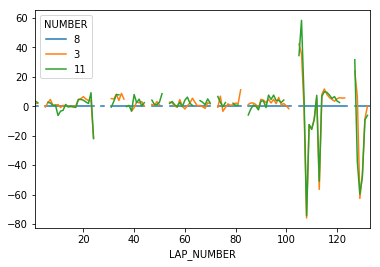

In [300]:
masked_pace.T[['8','3','11']].plot();

Using the accumulated deltas we see the breaks more clearly, altough it should be recalled that these are introduced when *either* the rebased car *or* the reported on car goes through the pits.

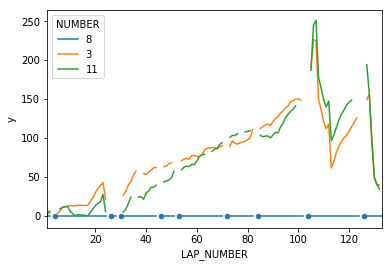

In [301]:
ax = masked_pace.T[['8','3','11']].cumsum().plot();
inpitlaps.plot.scatter(x='LAP_NUMBER',y='y', ax=ax);

In [283]:
laptimes.groupby('NUMBER')['PIT_TIME_S'].sum()[['8','3','11']]

NUMBER
8     520.523
3     512.932
11    499.722
Name: PIT_TIME_S, dtype: float64

## Neutralising Accumulated Pit Times

The gaps in the pit stop neutralised pace charts represent a loss of information.

If we want to concentrate on *pace* rather than on time lost through being spent in the pits, for each car we could provide a naive dummy estimate of the inlap and outlap pace by setting them each to:

`((inlap_time + outlap_time) - pitstop_time) / 2`.

However, we note that we also have access to sector times, so we might be able to make a better estimate based using sector times and a proportionate subtraction of the pit stop time from the inlap and outlap times.

To start working towards this, it might make sense to start pulling out pit data specifically.

In [338]:
pit_data = laptimes[laptimes['INLAP'] | laptimes['OUTLAP']][:]
pit_data['LAP_TYPE'] = pit_data['INLAP'].map({True:'INLAP', False:'OUTLAP'})
pit_data.head()

,NUMBER,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,...,LAP_TIME_S,ELAPSED_S,PIT_TIME_S,POS,leader,LEAD_LAP_NUMBER,INLAP,OUTLAP,PITMASK,LAP_TYPE
3988,97,2,2,2:23.253,0,B,39.232,0,1:02.685,0,...,143.253,287.748,NaN,24.0,False,2,True,False,True,INLAP
3864,95,2,2,2:23.401,0,B,38.885,0,1:03.277,0,...,143.401,289.380,NaN,26.0,False,2,True,False,True,INLAP
3258,86,1,2,2:33.997,0,B,42.113,0,1:06.298,0,...,153.997,315.518,NaN,34.0,False,2,True,False,True,INLAP
2383,7,1,3,2:14.361,0,B,36.637,0,57.067,0,...,134.361,372.899,NaN,1.0,True,3,True,False,True,INLAP
2878,8,1,3,2:13.904,0,B,36.357,0,56.361,0,...,133.904,373.937,NaN,3.0,False,3,True,False,True,INLAP


As a basis for comparison, let's see what the sector times were for the fastest 5 laps of the race:

In [342]:
pit_sector_cols = ['NUMBER','S1','S2','S3','PIT_TIME_S','LAP_TIME_S', 'LAP_NUMBER']

laptimes.sort_values('LAP_TIME_S').head()[pit_sector_cols]

,NUMBER,S1,S2,S3,PIT_TIME_S,LAP_TIME_S,LAP_NUMBER
2419,7,32.780,55.068,29.546,NaN,117.394,39
2428,7,32.905,54.863,29.626,NaN,117.394,48
2431,7,32.772,54.787,29.977,NaN,117.536,51
2444,7,32.754,55.459,29.757,NaN,117.970,64
2877,8,33.205,55.215,29.636,NaN,118.056,2


We can inspect the inlap and outlap sector times for a specific car to get a feel for how they behave:

In [343]:
pit_sector_cols.append('LAP_TYPE')

pit_data[pit_data['NUMBER'].isin(['8'])][pit_sector_cols].sort_values(['NUMBER','LAP_NUMBER'])

,NUMBER,S1,S2,S3,PIT_TIME_S,LAP_TIME_S,LAP_NUMBER,LAP_TYPE
2878,8,36.357,56.361,41.186,NaN,133.904,3,INLAP
2879,8,1:33.311,1:08.769,35.498,66.025,197.578,4,OUTLAP
2900,8,1:29.029,1:53.144,53.253,NaN,255.426,25,INLAP
2901,8,1:41.104,1:22.021,44.446,69.309,227.571,26,OUTLAP
2904,8,46.120,1:17.370,51.425,NaN,174.915,29,INLAP
2905,8,1:23.945,1:08.644,32.503,56.874,185.092,30,OUTLAP
2920,8,32.953,1:16.012,1:28.664,NaN,197.629,45,INLAP
2921,8,2:10.213,1:35.438,29.824,51.207,255.475,46,OUTLAP
2927,8,32.893,1:29.749,1:28.548,NaN,211.190,52,INLAP
2928,8,1:57.732,1:35.051,30.496,38.731,243.279,53,OUTLAP


In [346]:
pit_data[['LAP_TYPE','S1','S2','S3']].melt(id_vars='LAP_TYPE').head()

,LAP_TYPE,variable,value
0,INLAP,S1,39.232
1,INLAP,S1,38.885
2,INLAP,S1,42.113
3,INLAP,S1,36.637
4,INLAP,S1,36.357


How does the distribution of times on the inlap compare with the fastest lap sector times?

We might expect at least the third sector time to show an elevated time due to pit loss and perhaps an element of the pit stop time.

In [350]:
import plotly.express as px
fig = px.box(pit_data[pit_data['LAP_TYPE']=='INLAP'][['LAP_TYPE','S1','S2','S3']].melt(id_vars='LAP_TYPE'),
             x="variable", y="value")
fig.show()

How about the distribution on the outlap? We'd expect at least the first sector to have an elevated first sector time for a several reasons:

- it is likely to include a pit stop time and pit lane exit loss time;
- it make take time for the tyres to get up to speed.

In [351]:
fig = px.box(pit_data[pit_data['LAP_TYPE']=='OUTLAP'][['LAP_TYPE','S1','S2','S3']].melt(id_vars='LAP_TYPE'),
             x="variable", y="value")
fig.show()

For comparison, what are the sector time distributions for the 50 fastest laps, bearing in mind that the pit event distributions are from all cars and the 50 fastest lap distributions are likely from a more limited range of cars?

In [354]:
fig = px.box(laptimes.sort_values('LAP_TIME_S').head(50)[['S1','S2','S3']].melt(),
             x="variable", y="value")
fig.show()

In [382]:
#Which cars produced the 50 fastest laps?
laptimes.sort_values('LAP_TIME_S').head(50)['NUMBER'].unique()

array(['7', '8', '17', '1', '3', '11'], dtype=object)

A better comparison would be to have the box plots side by side for inlap, outlap, and flying lap: